In [1]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.cytoselfmodule import CytoselfLightningModule
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt



BASE_DIR = "/home/ec2-user/outputs/cytoself/2023-08-03/05-45-38" # 21 epochs 
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    clm = CytoselfLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
    )

    clm.model.to('cuda')
    clm.model.eval()

/tmp/ipykernel_117188/3318504357.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/cytoself/2023-08-03/05-45-38/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/datamodule.py:39: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../outputs/cytoself/2023-08-03/05-45-38/checkpoints/last.ckpt`
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


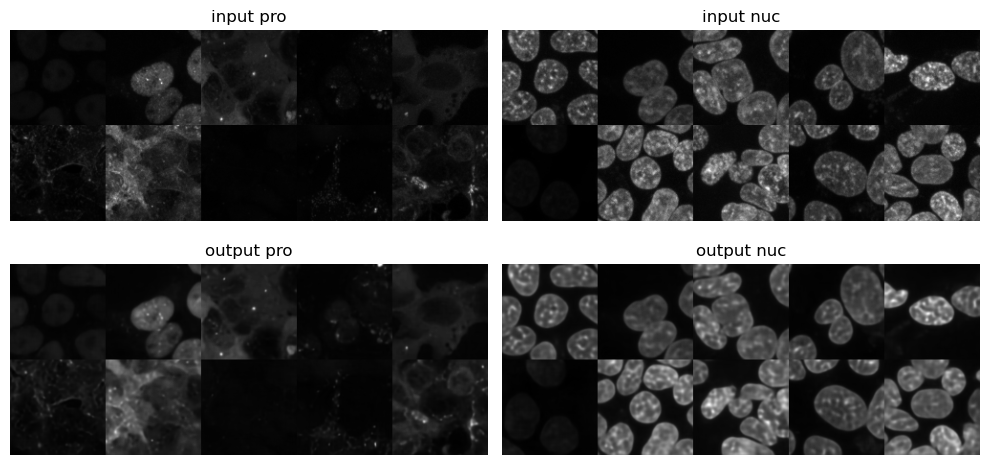

In [2]:
batch = next(iter(pdm.val_dataloader(novel_proteins=False, shuffle=True)))
input_images = batch['image'].to('cuda')
output_images, output_logits = clm.model(input_images)
output_images = output_images.detach().cpu().numpy()
input_images = input_images.detach().cpu().numpy()


data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(input_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(output_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [3]:
dl = pdm.val_dataloader(novel_proteins=False, shuffle=False)

In [24]:
# pdm.train_dataset.labels = pdm.train_dataset.labels[pdm.train_dataset.labels['localization'] != '']
# dl = pdm.train_dataloader()

In [4]:
import torch
from tqdm import tqdm


embeddings = []
index = []
with torch.no_grad():
    for batch in tqdm(dl):
        emb = clm.model(batch['image'].to('cuda'), 'vqvec2')
        embeddings.append(emb.detach().cpu().numpy())
        index.append(batch['index'].detach().cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
index = np.concatenate(index, axis=0)

100%|██████████| 1435/1435 [01:26<00:00, 16.51it/s]


In [5]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "cytoself_embeddings_vqvec2_2023-08-03_05-45-38_val_images_train_proteins.zarr")

shape = embeddings.shape
chunks = (100, None, None, None)
z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
z[:] = embeddings

# np.save(join(datapath, "good_localizations_redo21.npy"), localizations)
# np.save(join(datapath, "good_names_redo21.npy"), names)
# np.save(join(datapath, "good_complexes_redo21.npy"), complexes)
# np.save(join(datapath, "good_complexes_fig_redo21.npy"), complexes_fig)
# embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
# localizations = np.load(join(datapath, "good_localizations_redo21.npy"))
# names = np.load(join(datapath, "good_names_redo21.npy"))
# complexes = np.load(join(datapath, "good_complexes_redo21.npy"))
# complexes_fig = np.load(join(datapath, "good_complexes_fig_redo21.npy"))


In [20]:
names = np.array(dl.dataset.labels['name'])
localizations = np.array(dl.dataset.labels['localization'])
complexes = np.array(dl.dataset.labels['complex'])
complexes_fig = np.array(dl.dataset.labels['complex_fig'])

In [123]:
# import zarr
# from os.path import join
# import numpy as np

# datapath = "/home/ec2-user/cytoself-data/"
# zarr_path = join(datapath, "good_embeddings_redo21_train.zarr")

# # shape = embeddings.shape
# # chunks = (100, None, None, None)
# # z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
# # z[:] = embeddings

# # np.save(join(datapath, "good_localizations_redo21_train.npy"), localizations)
# # np.save(join(datapath, "good_names_redo21_train.npy"), names)
# # np.save(join(datapath, "good_complexes_redo21_train.npy"), complexes)
# # np.save(join(datapath, "good_complexes_fig_redo21_train.npy"), complexes_fig)

# embeddings_train = np.asarray(zarr.open(zarr_path, mode='r'))
# localizations_train = np.load(join(datapath, "good_localizations_redo21_train.npy"))
# names_train = np.load(join(datapath, "good_names_redo21_train.npy"))
# complexes_train = np.load(join(datapath, "good_complexes_redo21_train.npy"))
# complexes_fig_train = np.load(join(datapath, "good_complexes_fig_redo21_train.npy"))


In [45]:
# names_train_avg = np.unique(names_train)
# embeddings_train_avg = []

# for name in names_train_avg:
#     keep = names_train == name
#     embeddings_train_avg.append(np.median(embeddings_train[keep], axis=0))
# embeddings_train_avg = np.array(embeddings_train_avg)

In [4]:
# names_train_avg = np.unique(names_train)
# embeddings_avg = []

# for name in names_train_avg:
#     keep = names == name
#     embeddings_avg.append(np.median(embeddings[keep], axis=0))
# embeddings_avg = np.array(embeddings_avg)

In [5]:
# # np.save(join(datapath, "good_names_redo21_train_avg.npy"), names_train_avg)
# # np.save(join(datapath, "good_embeddings_redo21_train_avg.npy"), embeddings_train_avg)

# names_train_avg = np.load(join(datapath, "good_names_redo21_train_avg.npy"))
# embeddings_train_avg = np.load(join(datapath, "good_embeddings_redo21_train_avg.npy"))

In [9]:
# embeddings_train = embeddings
# localizations_train = localizations
# names_train = names
# complexes_train = complexes
# complexes_fig_train = complexes_fig

In [114]:
# localizations[localizations == ''] = 'other'
# complexes[complexes == ''] = 'other'
# complexes_fig[complexes_fig == ''] = 'other'

In [115]:
# localizations_train[localizations_train == ''] = 'other'
# complexes_train[complexes_train == ''] = 'other'
# complexes_fig_train[complexes_fig_train == ''] = 'other'

In [14]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [15]:
from joblib import dump
from joblib import load

dump(reducer, join(datapath,'cytoself_umap_model_2023-08-03_05-45-38.joblib'))

# reducer = load(join(datapath,'cytoself_umap_model_redo21_2023-08-03_05-45-38.joblib'))

['/home/ec2-user/cytoself-data/cytoself_umap_model_redo21_2023-08-03_05-45-38.joblib']

In [16]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

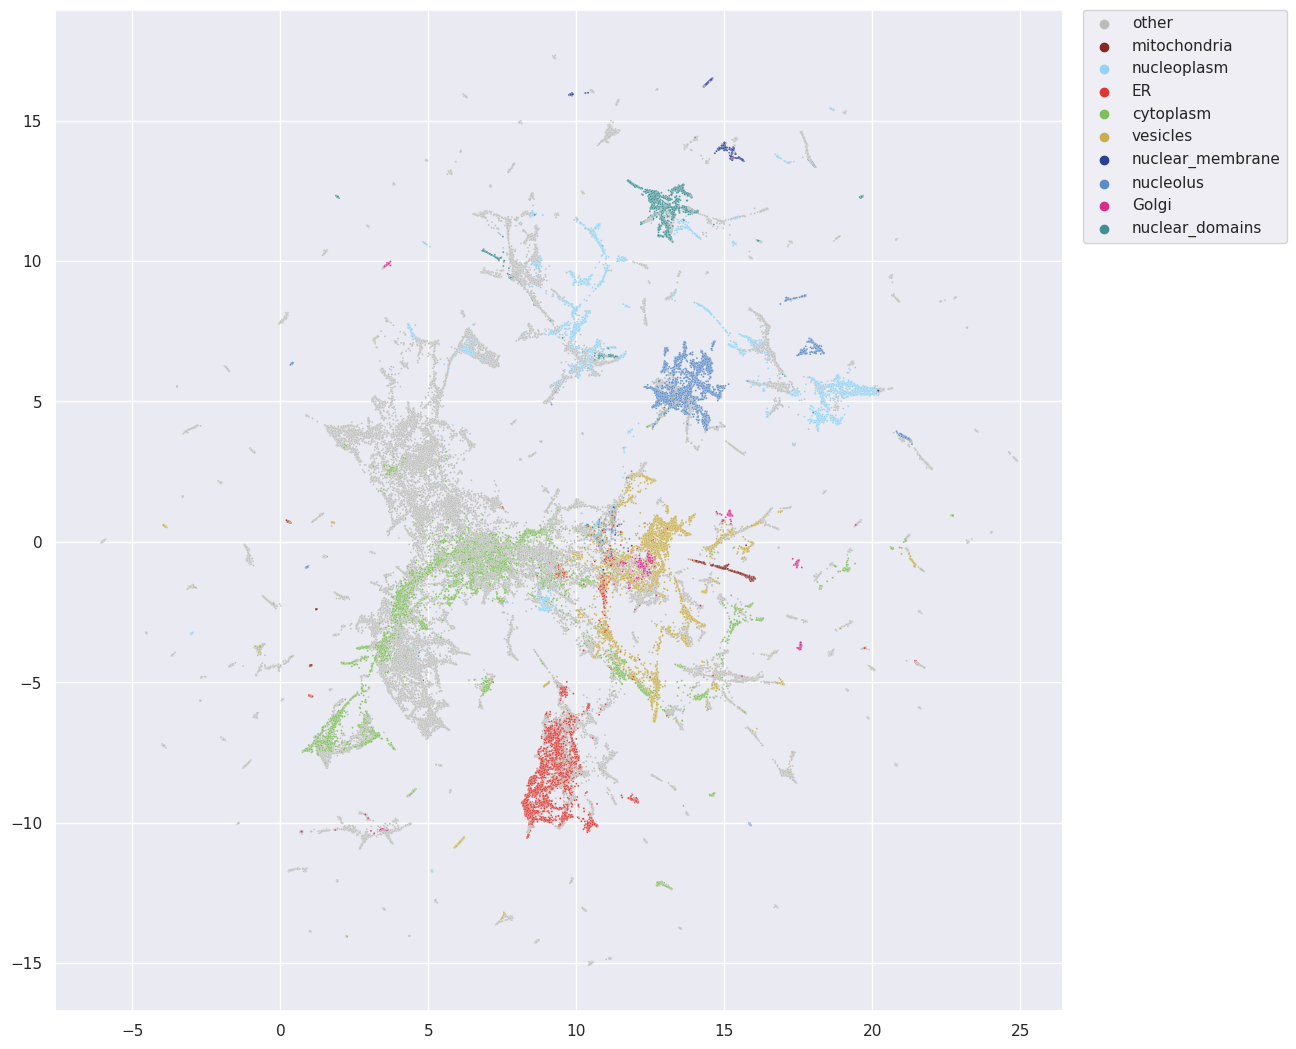

In [19]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

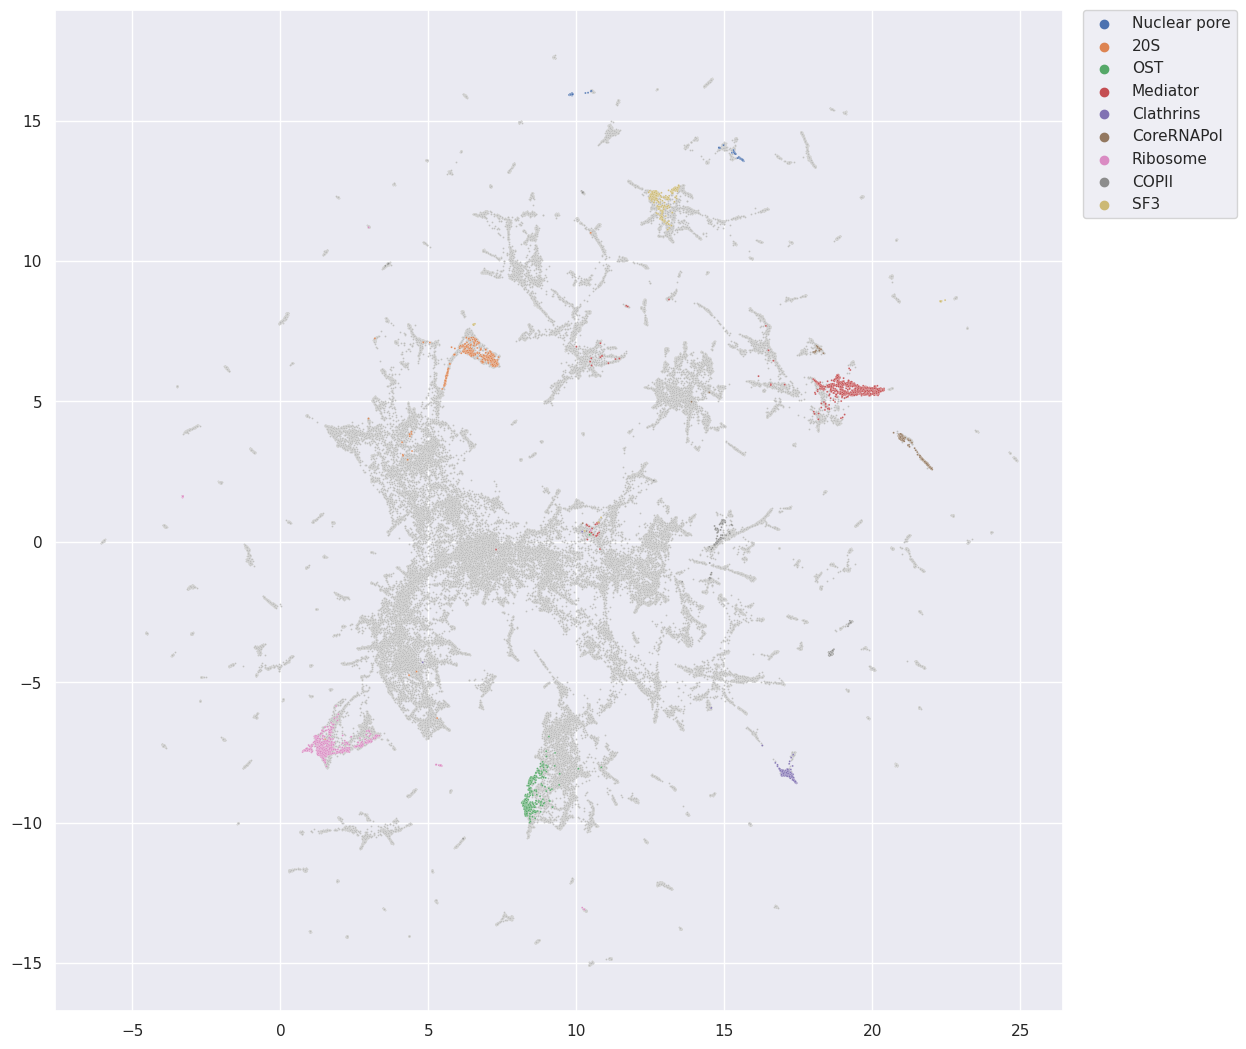

In [21]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=complexes_fig[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

In [11]:
# sns.set(rc={"figure.figsize":(13, 13)})
# other = complexes_fig != 'Ribosome'
# sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
# re = reduced_embedding[~other]
# n = names[~other]
# p = np.random.permutation(len(n))
# sns.scatterplot(x=re[p, 0], y=re[p, 1], hue=n[p], s=2, alpha=0.9)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
# plt.xlim([5, 10])
# plt.ylim([16.5, 21.5])

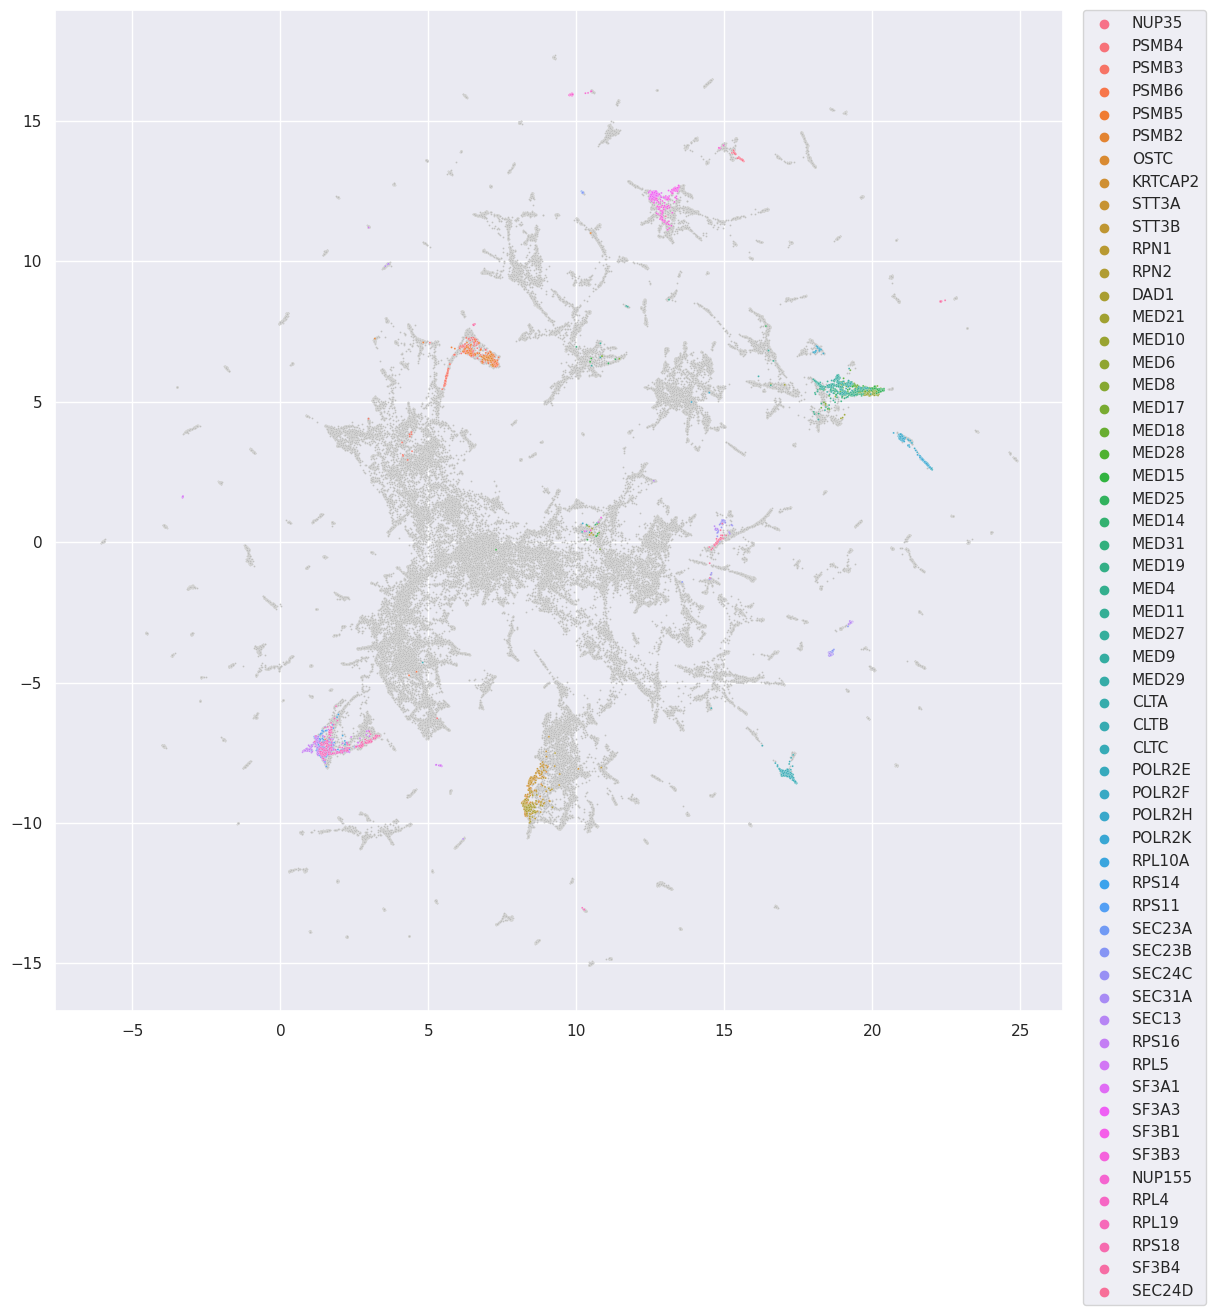

In [22]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=names[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

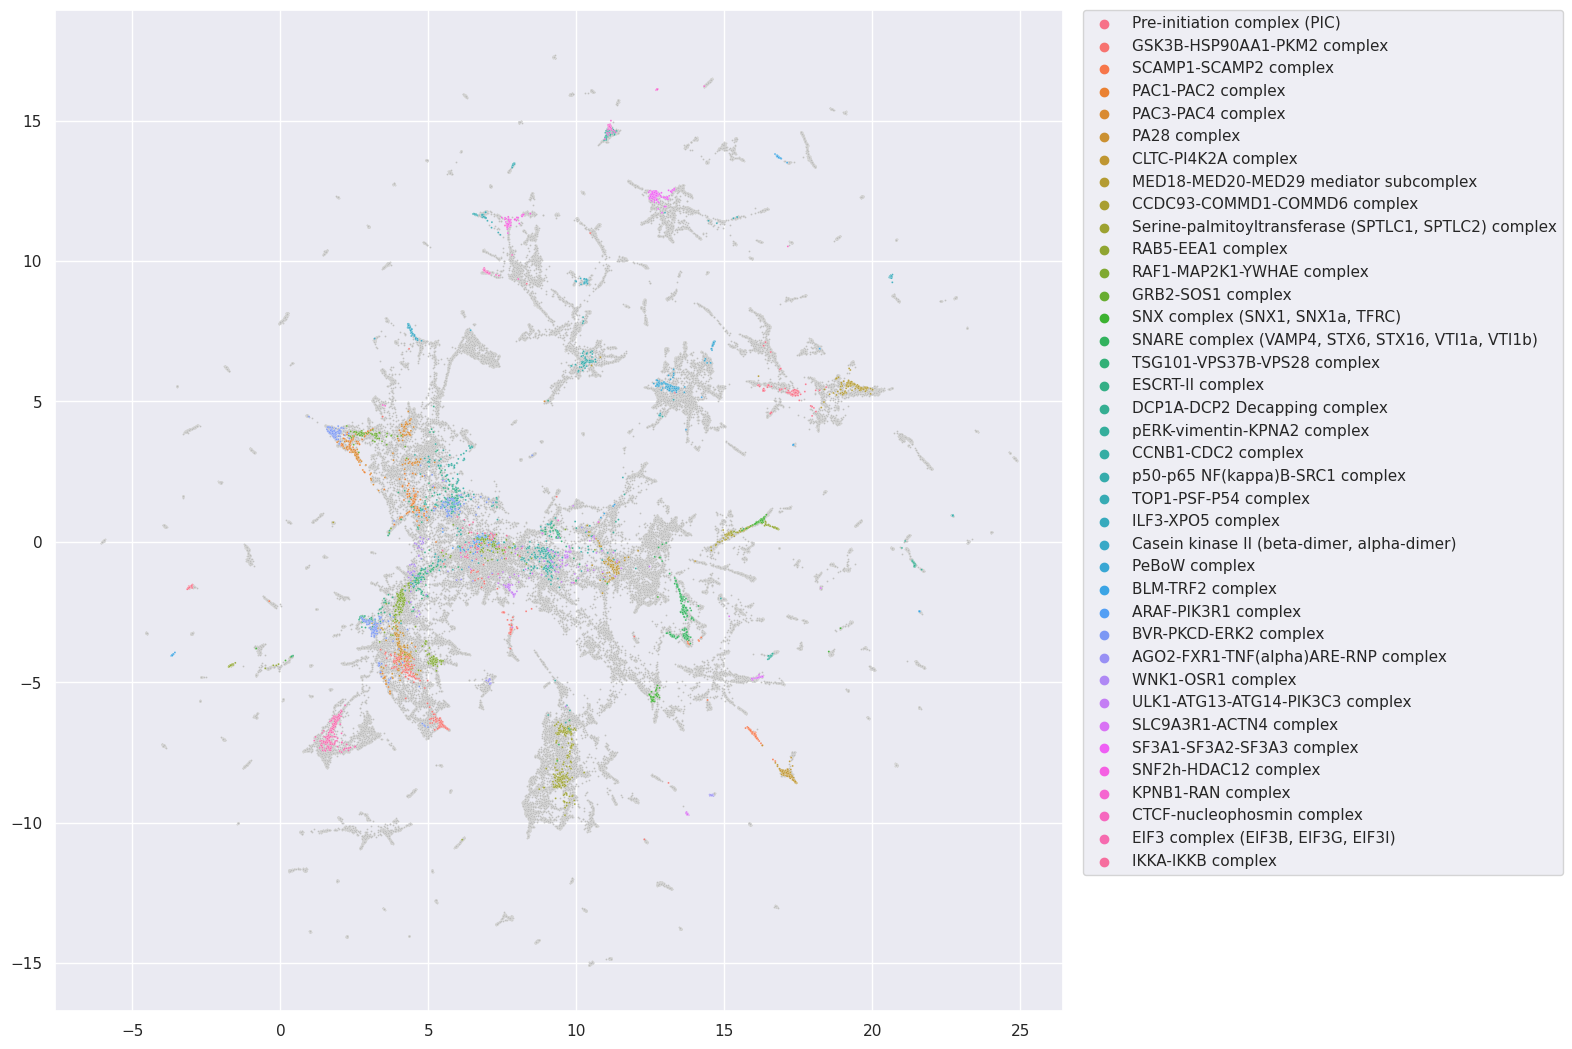

: 

In [23]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=complexes[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

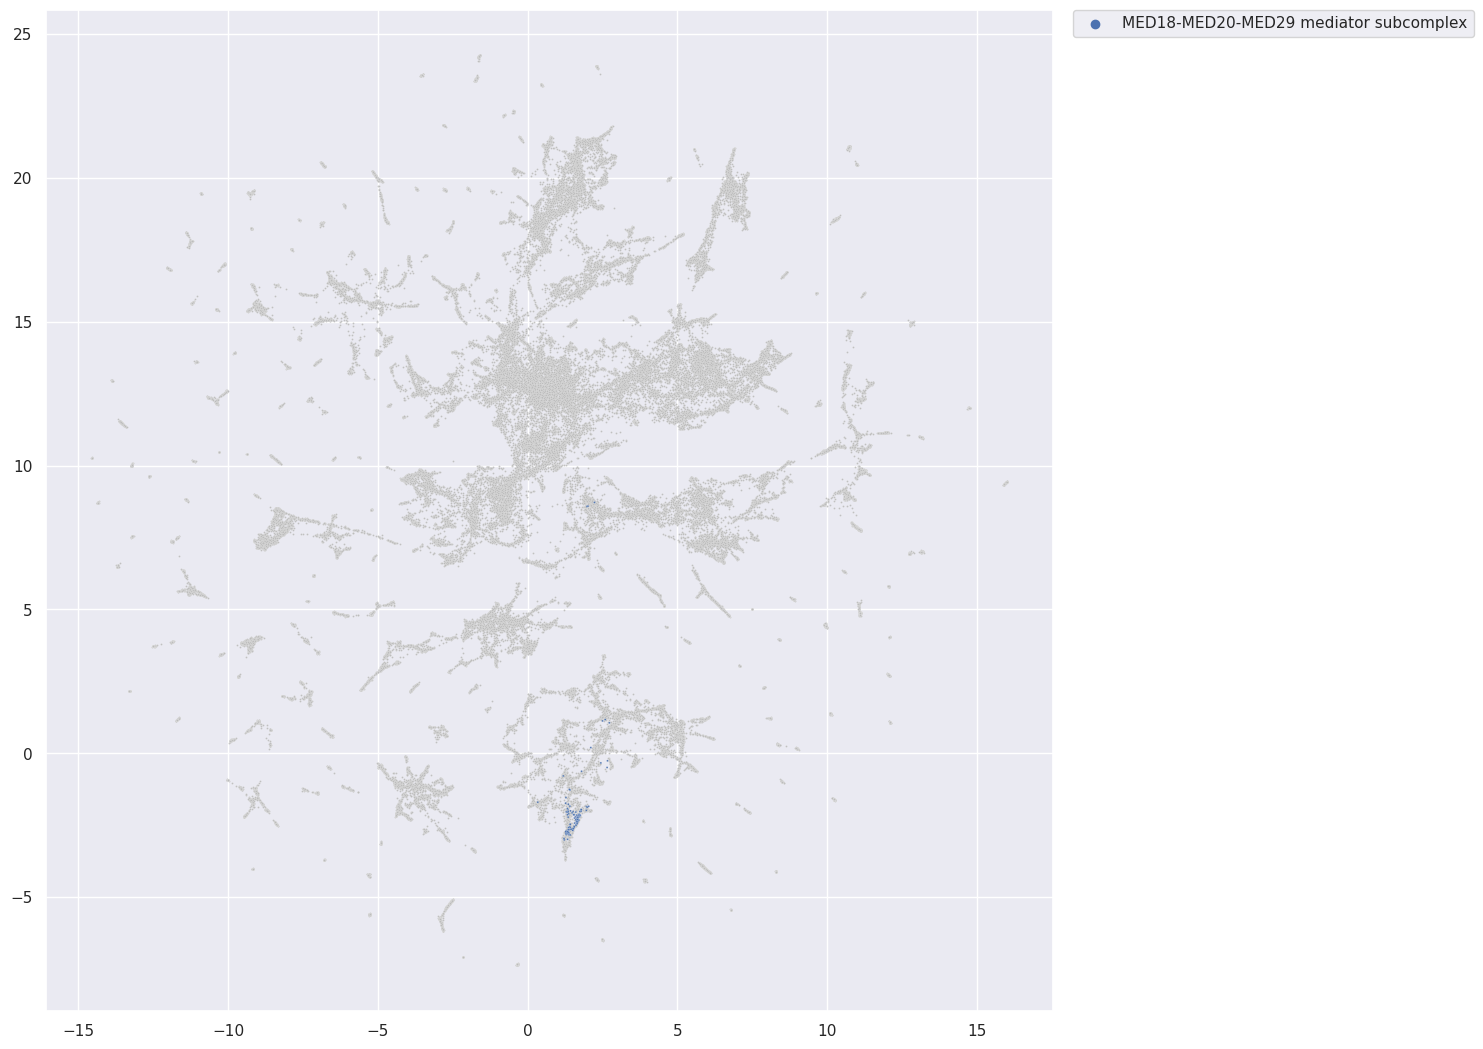

In [122]:
sns.set(rc={"figure.figsize":(13, 13)})
# other = complexes == 'other'
other = complexes != 'MED18-MED20-MED29 mediator subcomplex'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=complexes[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### Score clustering

In [15]:
def robust_mean(cluster):
    return np.median(cluster, axis=0)


def robust_std(cluster):
    # Compute the median sum of square distance
    median = robust_mean(cluster)
    std = np.median(np.sqrt(((cluster - median)**2).sum(axis=1)), axis=0)
    return std


def clustering_score(clusters):
    means = [robust_mean(cluster) for cluster in clusters]
    stds = [robust_std(cluster) for cluster in clusters]
    
    # numerator = robust_std(means)
    # denominator = robust_mean(stds)

    numerator = np.std(means, axis=0)
    denominator = np.median(stds, axis=0)


    individual_scores = numerator / denominator
    
    # Assuming that you want to average the individual scores for the final score
    final_score = np.mean(individual_scores)
    
    return final_score

In [16]:
labels = np.unique(localizations)
labels = labels[labels != 'other']
clusters = [reduced_embedding[localizations == label] for label in labels]
print(np.mean([len(c) for c in clusters]))
clustering_score(clusters)

3766.222222222222


3.7212765

In [17]:
# labels = np.unique(complexes)
# labels = labels[labels != 'other']
import pandas as pd

X = pd.DataFrame({'complexes':complexes, 'names':names}).drop_duplicates('names')
Z = X.value_counts('complexes')
Z = Z[Z.index != 'other']
labels = list(Z[Z != 1].index)

clusters = [reduced_embedding[complexes == label] for label in labels]
print(np.mean([len(c) for c in clusters]))
clustering_score(clusters)

194.57142857142858


9.33728

In [68]:
len(labels)

28

### Logistic regression for organelle classification

In [18]:
from sklearn.linear_model import LogisticRegression

other = localizations_train == 'other'
X_train = embeddings_train[~other]
X_train = X_train.reshape((X_train.shape[0], -1))
y_train = localizations_train[~other]

other = localizations == 'other'
X_test = embeddings[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = localizations[~other]

In [19]:
np.unique(localizations_train)

array(['ER', 'Golgi', 'cytoplasm', 'mitochondria', 'nuclear_domains',
       'nuclear_membrane', 'nucleolus', 'nucleoplasm', 'other',
       'vesicles'], dtype='<U16')

In [20]:
# clf = LogisticRegression(random_state=0, penalty='l2', C=1.0).fit(X_train, y_train)

In [21]:
from joblib import load

# Load the model from the file
clf = load('good_localization_classifier_redo21.joblib')


In [22]:
y_predict = clf.predict(X_test)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_train)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.9726516403115412


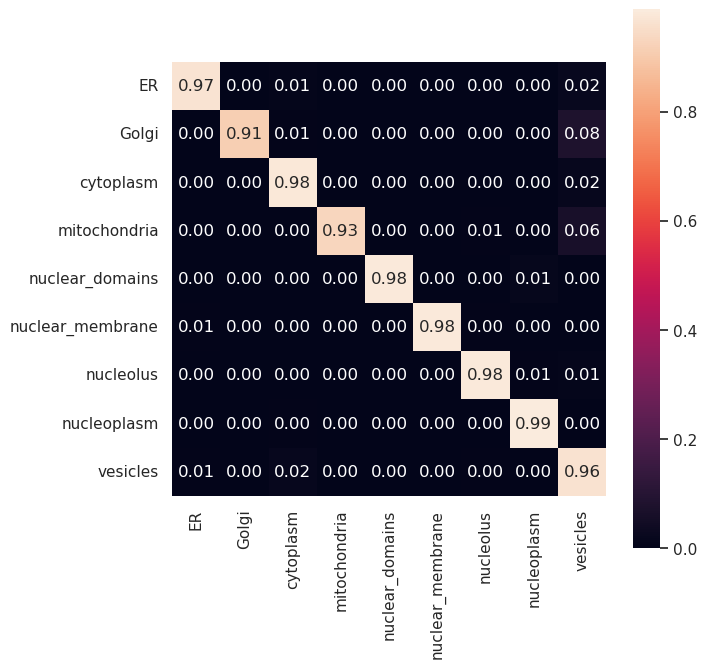

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [25]:
# from joblib import dump

# # Save the model to a file
# dump(clf, 'good_localization_classifier_redo21.joblib')

## kNN results avg

In [6]:
from annoy import AnnoyIndex

f = embeddings_train_avg[0].size  # dimension of the vector
index = AnnoyIndex(f, metric='euclidean')

# Build the index with vectors from A
for i, v in enumerate(embeddings_train_avg.reshape(embeddings_train_avg.shape[0], -1)):
    index.add_item(i, v)
index.build(100)  # 10 trees, can be adjusted based on precision requirements

True

In [92]:
k = 250
indices_list = []
for v in embeddings_avg:
    closest_indices = index.get_nns_by_vector(v.reshape(-1), k)
    indices_list.append(closest_indices)
indices_list = np.array(indices_list)

In [93]:
closest_names = names_train_avg[indices_list]
matches = closest_names == names_train_avg[:, np.newaxis]

In [94]:
# frac = matches.mean(axis=1)
# frac.mean()
matches[:, 0].mean()

0.9952335557673975

In [95]:
scores = []
for j in range(1, matches.shape[1]):
    scores.append(matches[:, :j].any(axis=1).mean())

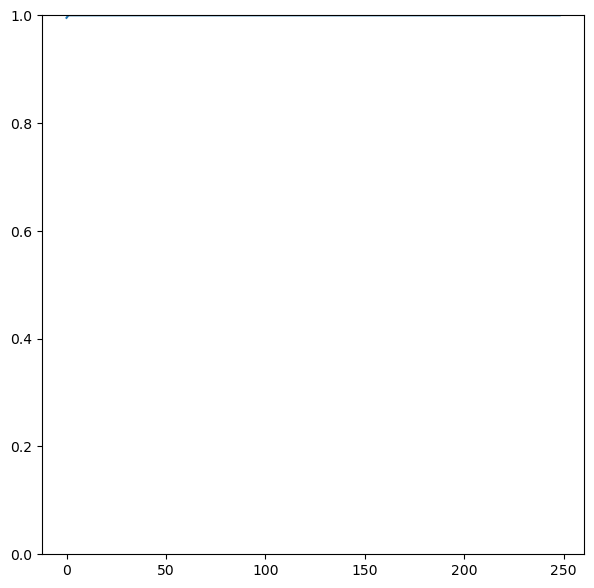

In [96]:
plt.figure(figsize=(7, 7))
plt.plot(scores);
plt.ylim([0, 1]);

In [134]:
from annoy import AnnoyIndex

f = embeddings_train[0].size  # dimension of the vector
index = AnnoyIndex(f, metric='euclidean')

# Build the index with vectors from A
for i, v in enumerate(embeddings_train.reshape(embeddings_train.shape[0], -1)):
    index.add_item(i, v)
index.build(100)  # 10 trees, can be adjusted based on precision requirements

True

In [136]:
embeddings_train.shape

(734598, 64, 4, 4)

In [151]:
k = 100
indices_list = []
for v in embeddings:
    closest_indices = index.get_nns_by_vector(v.reshape(-1), k)
    indices_list.append(closest_indices)
indices_list = np.array(indices_list)

In [152]:
indices_list.max()

734597

In [153]:
closest_names = names_train[indices_list]
matches = closest_names == names[:, np.newaxis]

In [154]:
scores = []
for j in range(1, matches.shape[1]):
    scores.append(matches[:, :j].any(axis=1).mean())

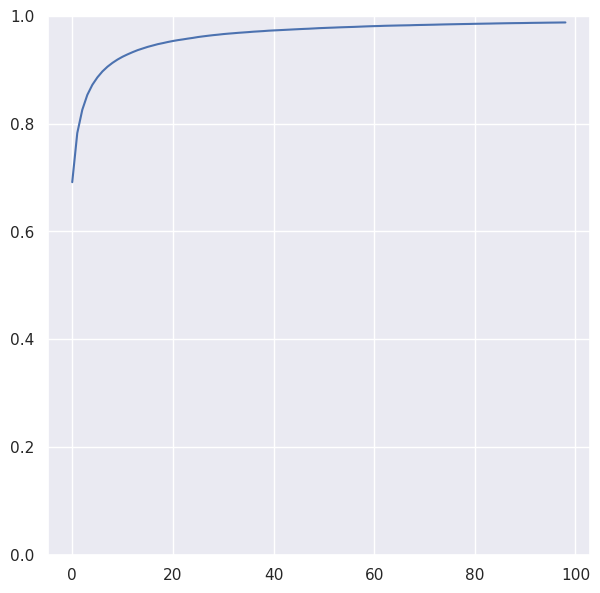

In [155]:
plt.figure(figsize=(7, 7))
plt.plot(scores);
plt.ylim([0, 1]);

## SSIM Scores for images

## CORUM data

In [98]:
import pandas as pd

In [143]:
X = pd.DataFrame({'complexes':complexes, 'names':names}).drop_duplicates()
complex_members = X.groupby('complexes')['names'].apply(list).to_dict()
del complex_members['other']
complex_members = {key: val for key, val in complex_members.items() if len(val) == 2}

In [144]:
len(complex_members)

21

In [156]:
pairwise_dist = {}

for k, v in complex_members.items():
    n0, n1 = v
    matches = closest_names[names == n0]
    match = np.where(matches == n1)[1]
    
    if len(match) == 0:
        pairwise_dist[k] = [np.nan]
    else:
        pairwise_dist[k] = [match[0]]

    matches = closest_names[names == n1]
    match = np.where(matches == n0)[1]
    
    if len(match) == 0:
        pairwise_dist[k].append(np.nan)
    else:
        pairwise_dist[k].append(match[0])

In [157]:
pairwise_dist

{'BLM-TRF2 complex': [49, 74],
 'CCDC93-COMMD1-COMMD6 complex': [88, 10],
 'CCNB1-CDC2 complex': [10, 17],
 'CLTC-PI4K2A complex': [nan, nan],
 'EIF3 complex (EIF3B, EIF3G, EIF3I)': [12, 43],
 'ESCRT-II complex': [nan, nan],
 'ILF3-XPO5 complex': [nan, nan],
 'KPNB1-RAN complex': [nan, nan],
 'MED18-MED20-MED29 mediator subcomplex': [3, 14],
 'PA28 complex': [2, 14],
 'PAC1-PAC2 complex': [nan, nan],
 'PAC3-PAC4 complex': [nan, nan],
 'RAB5-EEA1 complex': [15, nan],
 'SF3A1-SF3A2-SF3A3 complex': [3, 0],
 'SLC9A3R1-ACTN4 complex': [nan, nan],
 'SNX complex (SNX1, SNX1a, TFRC)': [nan, nan],
 'Serine-palmitoyltransferase (SPTLC1, SPTLC2) complex': [5, 32],
 'TOP1-PSF-P54 complex': [nan, nan],
 'TSG101-VPS37B-VPS28 complex': [nan, nan],
 'ULK1-ATG13-ATG14-PIK3C3 complex': [34, 1],
 'p50-p65 NF(kappa)B-SRC1 complex': [nan, nan]}

In [158]:
complex_members

{'BLM-TRF2 complex': ['BLM', 'TERF2'],
 'CCDC93-COMMD1-COMMD6 complex': ['CCDC93', 'COMMD1'],
 'CCNB1-CDC2 complex': ['CCNB1', 'CDK1'],
 'CLTC-PI4K2A complex': ['PI4K2A', 'CLTC'],
 'EIF3 complex (EIF3B, EIF3G, EIF3I)': ['EIF3G', 'EIF3B'],
 'ESCRT-II complex': ['VPS25', 'VPS36'],
 'ILF3-XPO5 complex': ['ILF3', 'XPO5'],
 'KPNB1-RAN complex': ['KPNB1', 'RAN'],
 'MED18-MED20-MED29 mediator subcomplex': ['MED18', 'MED29'],
 'PA28 complex': ['PSME2', 'PSME1'],
 'PAC1-PAC2 complex': ['PSMG1', 'PSMG2'],
 'PAC3-PAC4 complex': ['PSMG3', 'PSMG4'],
 'RAB5-EEA1 complex': ['RAB5A', 'EEA1'],
 'SF3A1-SF3A2-SF3A3 complex': ['SF3A1', 'SF3A3'],
 'SLC9A3R1-ACTN4 complex': ['SLC9A3R1', 'ACTN4'],
 'SNX complex (SNX1, SNX1a, TFRC)': ['SNX1', 'TFRC'],
 'Serine-palmitoyltransferase (SPTLC1, SPTLC2) complex': ['SPTLC2', 'SPTLC1'],
 'TOP1-PSF-P54 complex': ['TOP1', 'NONO'],
 'TSG101-VPS37B-VPS28 complex': ['TSG101', 'VPS28'],
 'ULK1-ATG13-ATG14-PIK3C3 complex': ['ULK1', 'ATG14'],
 'p50-p65 NF(kappa)B-SRC1 comple

In [102]:
np.where(matches == n1)[0]

array([], dtype=int64)

In [103]:
v

['NCOA1', 'NFKB1']

In [104]:
matches

array([['NCOA1', 'WAPL', 'USP22', 'ATM', 'HSF1', 'ARID1B', 'ANKRD11',
        'NET1', 'IPO13', 'POLR2D', 'AKT1', 'GNL3', 'POLR3G', 'RBM41',
        'CDC20', 'LPCAT1', 'TAF12', 'VASP', 'JUNB', 'CDK13', 'PATZ1',
        'CHEK2', 'SMARCAL1', 'DHCR24', 'EMC9', 'ALG2', 'SMARCA2',
        'MYL6B', 'LIG1', 'STIM1', 'SCD5', 'MRTO4', 'CDC26', 'ALDH16A1',
        'CCNB1', 'LARP7', 'SLC33A1', 'GPAT3', 'RAB8B', 'ATP6V1B2',
        'CLIP1', 'PES1', 'EMC10', 'INO80', 'ANKRD10', 'MED29', 'MED15',
        'POLR3GL', 'MKNK2', 'BET1', 'DEGS1', 'KDSR', 'DNTTIP1', 'RANGRF',
        'ARHGAP17', 'PIK3C2A', 'MED4', 'AGPAT2', 'ELOVL6', 'CYP51A1',
        'MED8', 'EMG1', 'PTDSS2', 'RBM34', 'TRIM28', 'ATP6V1E1',
        'ANAPC4', 'COMMD2', 'ARHGAP21', 'ARHGAP11A', 'GGPS1', 'SPTLC2',
        'SEPTIN8', 'CDC42BPB', 'INPP4A', 'NOL11', 'RABEP1', 'ULK1',
        'MYH9', 'GPAT4', 'PHAX', 'MED17', 'SMARCC2', 'MYO9B', 'PIP4K2A',
        'RBM7', 'WDR3', 'CEP72', 'CKAP4', 'WDR12', 'HDAC2', 'CLPTM1',
        'BNIP1', 'RAB

In [105]:
pairwise_dist

{'BLM-TRF2 complex': nan,
 'CCDC93-COMMD1-COMMD6 complex': 7,
 'CCNB1-CDC2 complex': 90,
 'CLTC-PI4K2A complex': 224,
 'EIF3 complex (EIF3B, EIF3G, EIF3I)': 3,
 'ESCRT-II complex': 144,
 'ILF3-XPO5 complex': nan,
 'KPNB1-RAN complex': nan,
 'MED18-MED20-MED29 mediator subcomplex': 2,
 'PA28 complex': 1,
 'PAC1-PAC2 complex': 170,
 'PAC3-PAC4 complex': 209,
 'RAB5-EEA1 complex': nan,
 'SF3A1-SF3A2-SF3A3 complex': 1,
 'SLC9A3R1-ACTN4 complex': nan,
 'SNX complex (SNX1, SNX1a, TFRC)': 167,
 'Serine-palmitoyltransferase (SPTLC1, SPTLC2) complex': 29,
 'TOP1-PSF-P54 complex': nan,
 'TSG101-VPS37B-VPS28 complex': nan,
 'ULK1-ATG13-ATG14-PIK3C3 complex': nan,
 'p50-p65 NF(kappa)B-SRC1 complex': nan}

In [106]:
complex_members

{'BLM-TRF2 complex': ['BLM', 'TERF2'],
 'CCDC93-COMMD1-COMMD6 complex': ['CCDC93', 'COMMD1'],
 'CCNB1-CDC2 complex': ['CCNB1', 'CDK1'],
 'CLTC-PI4K2A complex': ['PI4K2A', 'CLTC'],
 'EIF3 complex (EIF3B, EIF3G, EIF3I)': ['EIF3G', 'EIF3B'],
 'ESCRT-II complex': ['VPS25', 'VPS36'],
 'ILF3-XPO5 complex': ['ILF3', 'XPO5'],
 'KPNB1-RAN complex': ['KPNB1', 'RAN'],
 'MED18-MED20-MED29 mediator subcomplex': ['MED18', 'MED29'],
 'PA28 complex': ['PSME2', 'PSME1'],
 'PAC1-PAC2 complex': ['PSMG1', 'PSMG2'],
 'PAC3-PAC4 complex': ['PSMG3', 'PSMG4'],
 'RAB5-EEA1 complex': ['RAB5A', 'EEA1'],
 'SF3A1-SF3A2-SF3A3 complex': ['SF3A1', 'SF3A3'],
 'SLC9A3R1-ACTN4 complex': ['SLC9A3R1', 'ACTN4'],
 'SNX complex (SNX1, SNX1a, TFRC)': ['SNX1', 'TFRC'],
 'Serine-palmitoyltransferase (SPTLC1, SPTLC2) complex': ['SPTLC2', 'SPTLC1'],
 'TOP1-PSF-P54 complex': ['TOP1', 'NONO'],
 'TSG101-VPS37B-VPS28 complex': ['TSG101', 'VPS28'],
 'ULK1-ATG13-ATG14-PIK3C3 complex': ['ULK1', 'ATG14'],
 'p50-p65 NF(kappa)B-SRC1 comple

In [90]:
closest_names[names_train_avg == 'BLM']

array([['BLM', 'CKAP5', 'CLASP1', 'NHP2', 'RBM12B', 'NXF1', 'CCDC86',
        'DYNC1H1', 'POLR2H', 'UTP4', 'KIF11', 'TMA16', 'CLIP1', 'KIF7',
        'RABGAP1L', 'GNL2', 'ALDH16A1', 'RABGAP1', 'CDK1', 'NSA2',
        'DYNC2LI1', 'LIG1', 'SNX9', 'MVB12A', 'FAM120A', 'ATP6V0A2',
        'RBM6', 'FXR2', 'DYNC1I2', 'RBM15', 'INPP5E', 'CEP85', 'UTP6',
        'NVL', 'GOLT1B', 'RBM10', 'KIF3A', 'ARL6IP6', 'KIFAP3', 'TUBB4B',
        'NOP53', 'WASL', 'ANKRD13A', 'GYG2', 'CEP170', 'KIF1B', 'FDPS',
        'KIF3B', 'COIL', 'WIPF2']], dtype='<U9')

In [91]:
closest_names[names_train_avg == 'TERF2']

array([['TERF2', 'MIS12', 'POLR3H', 'LIG1', 'AURKB', 'RBM12B',
        'C18orf21', 'SLK', 'USP10', 'WASF2', 'NSA2', 'EIF2S3', 'EIF3K',
        'ZCCHC7', 'INPP5E', 'WASF1', 'NOL10', 'MYO9B', 'SLC7A6', 'LTV1',
        'CDC42BPB', 'ZCCHC9', 'CEP72', 'CCNB1', 'NXF1', 'NOP53', 'ROCK1',
        'DNAJC2', 'CEP192', 'EIF3M', 'NRBP1', 'ARHGAP21', 'POLR3A',
        'SLC37A3', 'SPOUT1', 'BTF3', 'ANKZF1', 'ARHGEF12', 'KLC4',
        'VDAC2', 'SEPTIN8', 'GTPBP4', 'NIFK', 'NEMF', 'PDPK1', 'RICTOR',
        'RIOK3', 'RPS6KB1', 'GNL2', 'DYNC1H1']], dtype='<U9')

In [30]:
Z = Z[Z.index != 'other']

In [31]:
list(Z[Z != 1].index)

['SNARE complex (VAMP4, STX6, STX16, VTI1a, VTI1b)',
 'pERK-vimentin-KPNA2 complex',
 'Pre-initiation complex (PIC)',
 'RAF1-MAP2K1-YWHAE complex',
 'GSK3B-HSP90AA1-PKM2 complex',
 'PeBoW complex',
 'BVR-PKCD-ERK2 complex',
 'TOP1-PSF-P54 complex',
 'Serine-palmitoyltransferase (SPTLC1, SPTLC2) complex',
 'PAC3-PAC4 complex',
 'TSG101-VPS37B-VPS28 complex',
 'SLC9A3R1-ACTN4 complex',
 'SF3A1-SF3A2-SF3A3 complex',
 'ULK1-ATG13-ATG14-PIK3C3 complex',
 'RAB5-EEA1 complex',
 'p50-p65 NF(kappa)B-SRC1 complex',
 'SNX complex (SNX1, SNX1a, TFRC)',
 'PAC1-PAC2 complex',
 'MED18-MED20-MED29 mediator subcomplex',
 'KPNB1-RAN complex',
 'ILF3-XPO5 complex',
 'BLM-TRF2 complex',
 'CCDC93-COMMD1-COMMD6 complex',
 'ESCRT-II complex',
 'EIF3 complex (EIF3B, EIF3G, EIF3I)',
 'PA28 complex',
 'CCNB1-CDC2 complex',
 'CLTC-PI4K2A complex']

In [32]:
Z.value_counts()

2    21
1    10
3     6
4     1
dtype: int64

In [33]:
21 + 3 * 6 + 6

45